# Project 4 
## Power Outages Data Analysis
### Ethan Lam, A17799139

In [327]:
import pandas as pd
import numpy as np
import plotly.express as px
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

### Read in the dataset and clean it

In [2]:
data = pd.read_csv('data/outage.csv')

# Remove first column which is all NaN values
data = data.drop(columns='Unnamed: 0')
data = data.set_index('OBS')
data

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,"Friday, July 1, 2011",5:00:00 PM,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,"Sunday, May 11, 2014",6:38:00 PM,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,"Tuesday, October 26, 2010",8:00:00 PM,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,"Tuesday, June 19, 2012",4:30:00 AM,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,"Saturday, July 18, 2015",2:00:00 AM,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,"Tuesday, December 6, 2011",8:00:00 AM,...,59.90,19.90,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765
1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,NaN,NaN,...,59.90,19.90,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765
1532,2009,8.0,South Dakota,SD,RFC,West North Central,0.5,warm,"Saturday, August 29, 2009",10:54:00 PM,...,56.65,26.73,2038.3,1905.4,4.7,0.30,0.15,98.307744,1.692256,1.692256


In [3]:
data.isna().sum()

YEAR                          0
MONTH                         9
U.S._STATE                    0
POSTAL.CODE                   0
NERC.REGION                   0
CLIMATE.REGION                6
ANOMALY.LEVEL                 9
CLIMATE.CATEGORY              9
OUTAGE.START.DATE             9
OUTAGE.START.TIME             9
OUTAGE.RESTORATION.DATE      58
OUTAGE.RESTORATION.TIME      58
CAUSE.CATEGORY                0
CAUSE.CATEGORY.DETAIL       471
HURRICANE.NAMES            1462
OUTAGE.DURATION              58
DEMAND.LOSS.MW              705
CUSTOMERS.AFFECTED          443
RES.PRICE                    22
COM.PRICE                    22
IND.PRICE                    22
TOTAL.PRICE                  22
RES.SALES                    22
COM.SALES                    22
IND.SALES                    22
TOTAL.SALES                  22
RES.PERCEN                   22
COM.PERCEN                   22
IND.PERCEN                   22
RES.CUSTOMERS                 0
COM.CUSTOMERS                 0
IND.CUST

Where and when do major power outages tend to occur?

In [4]:
most_power_outage_state = data.groupby('U.S._STATE')['YEAR'].count().sort_values().index[-1]
most_year_power_outage = data.groupby('YEAR')['MONTH'].count().sort_values().index[-1]

In [5]:
most_power_outage_state

'California'

Turn time in columns, OUTAGE.START.DATE and OUTAGE.START.TIME, into type pd.Timestamp and combine the two into OUTAGE.START

In [6]:
most_year_power_outage

np.int64(2011)

In [7]:
data['OUTAGE.START.DATE'] = pd.to_datetime(data['OUTAGE.START.DATE'], format='%A, %B %d, %Y')
data['OUTAGE.START.TIME'] = pd.to_datetime(data['OUTAGE.START.TIME'], format='%I:%M:%S %p').dt.time

In [8]:
data['OUTAGE.START'] = data['OUTAGE.START.DATE'].dt.strftime('%A, %B %d, %Y') + ' ' + data['OUTAGE.START.TIME'].astype(str)
data

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01,17:00:00,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Friday, July 01, 2011 17:00:00"
2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11,18:38:00,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Sunday, May 11, 2014 18:38:00"
3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26,20:00:00,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Tuesday, October 26, 2010 20:00:00"
4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19,04:30:00,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Tuesday, June 19, 2012 04:30:00"
5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18,02:00:00,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Saturday, July 18, 2015 02:00:00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,2011-12-06,08:00:00,...,19.90,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765,"Tuesday, December 06, 2011 08:00:00"
1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,NaT,NaT,...,19.90,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765,NaN
1532,2009,8.0,South Dakota,SD,RFC,West North Central,0.5,warm,2009-08-29,22:54:00,...,26.73,2038.3,1905.4,4.7,0.30,0.15,98.307744,1.692256,1.692256,"Saturday, August 29, 2009 22:54:00"


Combine OUTAGE.RESTORATION.DATE and OUTAGE.RESTORATION.TIME into a new column, OUTAGE.RESTORATION

In [9]:
data['OUTAGE.RESTORATION.DATE'] = pd.to_datetime(data['OUTAGE.RESTORATION.DATE'], format='%A, %B %d, %Y')
data['OUTAGE.RESTORATION.TIME'] = pd.to_datetime(data['OUTAGE.RESTORATION.TIME'], format='%I:%M:%S %p').dt.time
data['OUTAGE.RESTORATION'] = data['OUTAGE.RESTORATION.DATE'].dt.strftime('%A, %B %d, %Y') + ' ' + data['OUTAGE.RESTORATION.TIME'].astype(str)
data

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01,17:00:00,...,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Friday, July 01, 2011 17:00:00","Sunday, July 03, 2011 20:00:00"
2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11,18:38:00,...,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Sunday, May 11, 2014 18:38:00","Sunday, May 11, 2014 18:39:00"
3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26,20:00:00,...,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Tuesday, October 26, 2010 20:00:00","Thursday, October 28, 2010 22:00:00"
4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19,04:30:00,...,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Tuesday, June 19, 2012 04:30:00","Wednesday, June 20, 2012 23:00:00"
5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18,02:00:00,...,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,"Saturday, July 18, 2015 02:00:00","Sunday, July 19, 2015 07:00:00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,2011-12-06,08:00:00,...,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765,"Tuesday, December 06, 2011 08:00:00","Tuesday, December 06, 2011 20:00:00"
1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,NaT,NaT,...,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765,NaN,NaN
1532,2009,8.0,South Dakota,SD,RFC,West North Central,0.5,warm,2009-08-29,22:54:00,...,2038.3,1905.4,4.7,0.30,0.15,98.307744,1.692256,1.692256,"Saturday, August 29, 2009 22:54:00","Saturday, August 29, 2009 23:53:00"


In [10]:
relevant = data[['YEAR', 'MONTH', 'U.S._STATE', 'POSTAL.CODE', 'NERC.REGION', 'CLIMATE.REGION', 'ANOMALY.LEVEL', 'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL', 'RES.SALES', 'OUTAGE.START', 'OUTAGE.RESTORATION', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED', 'RES.SALES', 'IND.SALES', 'COM.SALES', 'TOTAL.PRICE', 'TOTAL.SALES', 'TOTAL.CUSTOMERS', 'POPPCT_URBAN', 'POPDEN_URBAN', 'AREAPCT_URBAN']]


In [11]:
pd.set_option('display.max_columns', None)
relevant

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,RES.SALES,OUTAGE.START,OUTAGE.RESTORATION,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.SALES,IND.SALES,COM.SALES,TOTAL.PRICE,TOTAL.SALES,TOTAL.CUSTOMERS,POPPCT_URBAN,POPDEN_URBAN,AREAPCT_URBAN
OBS,,,,,,,,,,,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,severe weather,NaN,2332915.0,"Friday, July 01, 2011 17:00:00","Sunday, July 03, 2011 20:00:00",3060.0,NaN,70000.0,2332915.0,2113291.0,2114774.0,9.28,6562520.0,2595696,73.27,2279.0,2.14
2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,intentional attack,vandalism,1586986.0,"Sunday, May 11, 2014 18:38:00","Sunday, May 11, 2014 18:39:00",1.0,NaN,NaN,1586986.0,1887927.0,1807756.0,9.28,5284231.0,2640737,73.27,2279.0,2.14
3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,severe weather,heavy wind,1467293.0,"Tuesday, October 26, 2010 20:00:00","Thursday, October 28, 2010 22:00:00",3000.0,NaN,70000.0,1467293.0,1951295.0,1801683.0,8.15,5222116.0,2586905,73.27,2279.0,2.14
4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,severe weather,thunderstorm,1851519.0,"Tuesday, June 19, 2012 04:30:00","Wednesday, June 20, 2012 23:00:00",2550.0,NaN,68200.0,1851519.0,1993026.0,1941174.0,9.19,5787064.0,2606813,73.27,2279.0,2.14
5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,severe weather,NaN,2028875.0,"Saturday, July 18, 2015 02:00:00","Sunday, July 19, 2015 07:00:00",1740.0,250.0,250000.0,2028875.0,1777937.0,2161612.0,10.43,5970339.0,2673531,73.27,2279.0,2.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,12.0,North Dakota,ND,MRO,West North Central,-0.9,public appeal,NaN,488853.0,"Tuesday, December 06, 2011 08:00:00","Tuesday, December 06, 2011 20:00:00",720.0,155.0,34500.0,488853.0,386693.0,438133.0,7.56,1313678.0,394394,59.90,2192.2,0.27
1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,fuel supply emergency,Coal,NaN,NaN,NaN,NaN,1650.0,NaN,NaN,NaN,NaN,NaN,NaN,366037,59.90,2192.2,0.27
1532,2009,8.0,South Dakota,SD,RFC,West North Central,0.5,islanding,NaN,337874.0,"Saturday, August 29, 2009 22:54:00","Saturday, August 29, 2009 23:53:00",59.0,84.0,NaN,337874.0,215406.0,370771.0,7.67,924051.0,436229,56.65,2038.3,0.30


In [12]:
def standardize(df, col):
    return (df[col] - df[col].mean()) / df[col].std()

In [13]:
relevant['RES.SALES'] = standardize(data, 'RES.SALES')
relevant['IND.SALES'] = standardize(data, 'IND.SALES')
relevant['COM.SALES'] = standardize(data, 'COM.SALES')
relevant

C:\Users\Stikes PC\AppData\Local\Temp\ipykernel_18136\3675664561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant['RES.SALES'] = standardize(data, 'RES.SALES')
C:\Users\Stikes PC\AppData\Local\Temp\ipykernel_18136\3675664561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant['IND.SALES'] = standardize(data, 'IND.SALES')
C:\Users\Stikes PC\AppData\Local\Temp\ipykernel_18136\3675664561.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,RES.SALES,OUTAGE.START,OUTAGE.RESTORATION,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.SALES,IND.SALES,COM.SALES,TOTAL.PRICE,TOTAL.SALES,TOTAL.CUSTOMERS,POPPCT_URBAN,POPDEN_URBAN,AREAPCT_URBAN
OBS,,,,,,,,,,,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,severe weather,NaN,-0.594363,"Friday, July 01, 2011 17:00:00","Sunday, July 03, 2011 20:00:00",3060.0,NaN,70000.0,-0.594363,-0.308476,-0.660847,9.28,6562520.0,2595696,73.27,2279.0,2.14
2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,intentional attack,vandalism,-0.815220,"Sunday, May 11, 2014 18:38:00","Sunday, May 11, 2014 18:39:00",1.0,NaN,NaN,-0.815220,-0.410267,-0.748638,9.28,5284231.0,2640737,73.27,2279.0,2.14
3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,severe weather,heavy wind,-0.850659,"Tuesday, October 26, 2010 20:00:00","Thursday, October 28, 2010 22:00:00",3000.0,NaN,70000.0,-0.850659,-0.381646,-0.750375,8.15,5222116.0,2586905,73.27,2279.0,2.14
4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,severe weather,thunderstorm,-0.736896,"Tuesday, June 19, 2012 04:30:00","Wednesday, June 20, 2012 23:00:00",2550.0,NaN,68200.0,-0.736896,-0.362797,-0.710488,9.19,5787064.0,2606813,73.27,2279.0,2.14
5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,severe weather,NaN,-0.684384,"Saturday, July 18, 2015 02:00:00","Sunday, July 19, 2015 07:00:00",1740.0,250.0,250000.0,-0.684384,-0.459947,-0.647453,10.43,5970339.0,2673531,73.27,2279.0,2.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,12.0,North Dakota,ND,MRO,West North Central,-0.9,public appeal,NaN,-1.140358,"Tuesday, December 06, 2011 08:00:00","Tuesday, December 06, 2011 20:00:00",720.0,155.0,34500.0,-1.140358,-1.088336,-1.140282,7.56,1313678.0,394394,59.90,2192.2,0.27
1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,fuel supply emergency,Coal,NaN,NaN,NaN,NaN,1650.0,NaN,NaN,NaN,NaN,NaN,NaN,366037,59.90,2192.2,0.27
1532,2009,8.0,South Dakota,SD,RFC,West North Central,0.5,islanding,NaN,-1.185060,"Saturday, August 29, 2009 22:54:00","Saturday, August 29, 2009 23:53:00",59.0,84.0,NaN,-1.185060,-1.165702,-1.159544,7.67,924051.0,436229,56.65,2038.3,0.30


In [14]:
relevant = relevant.copy()
relevant['MONTH'] = pd.to_datetime(data['MONTH'], format='%m').dt.month_name().str.slice(stop=3)
print(relevant[['MONTH', 'U.S._STATE', 'CAUSE.CATEGORY', 'OUTAGE.START', 'IND.SALES', 'COM.SALES']].head().to_markdown(index=False))

| MONTH   | U.S._STATE   | CAUSE.CATEGORY     | OUTAGE.START                       |   IND.SALES |   COM.SALES |
|:--------|:-------------|:-------------------|:-----------------------------------|------------:|------------:|
| Jul     | Minnesota    | severe weather     | Friday, July 01, 2011 17:00:00     |   -0.308476 |   -0.660847 |
| May     | Minnesota    | intentional attack | Sunday, May 11, 2014 18:38:00      |   -0.410267 |   -0.748638 |
| Oct     | Minnesota    | severe weather     | Tuesday, October 26, 2010 20:00:00 |   -0.381646 |   -0.750375 |
| Jun     | Minnesota    | severe weather     | Tuesday, June 19, 2012 04:30:00    |   -0.362797 |   -0.710488 |
| Jul     | Minnesota    | severe weather     | Saturday, July 18, 2015 02:00:00   |   -0.459947 |   -0.647453 |


Now that our data is cleaned up, let's explore variables that would have
correlation to power outages

In [15]:
outages_per_state = relevant.groupby('U.S._STATE')['YEAR'].count().reset_index()
outages_per_state

,U.S._STATE,YEAR
0,Alabama,6
1,Alaska,1
2,Arizona,28
3,Arkansas,25
4,California,210
5,Colorado,15
6,Connecticut,18
7,Delaware,41
8,District of Columbia,10
9,Florida,45


In [16]:
us_states_geo = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
m = folium.Map(location=[37.8, -96], zoom_start=5)
folium.Choropleth(
    geo_data=us_states_geo,
    name="choropleth",
    data=outages_per_state,
    columns=['U.S._STATE', 'YEAR'],
    key_on="feature.properties.name",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Power Outages by State"
).add_to(m)

m

In [17]:
m.save("power_outages_choropleth.html")

In [18]:
num_causes = relevant.groupby('CAUSE.CATEGORY')[['YEAR']].count().sort_values(by='YEAR').rename(columns={'YEAR': 'Count'})
causes = px.bar(num_causes, title='Number of Outages Per Cause')
causes.show()
causes.write_html('causes_count.html')

In [19]:
num_states = relevant.groupby('U.S._STATE')['YEAR'].count().sort_values()
states = px.bar(num_states)
states.show()

In [20]:
num_year = relevant.groupby('YEAR')[['MONTH']].count().rename(columns={'MONTH': 'COUNT'})
year = px.line(num_year, title='Number of Outages Per Year')
year.show()
year.write_html('outages_yearly_count.html')

In [21]:
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
num_month = relevant.groupby('MONTH')[['YEAR']].count().rename(columns={'YEAR': 'COUNT'})
num_month = num_month.sort_index(key=lambda x: x.map(lambda month: month_order.index(month)))
month = px.line(num_month, title='Number of Outages Per Month')
month.show()
month.write_html('outages_monthly_count.html')

Now move on to two variable analysis

In [22]:
relevant.isna().sum()

YEAR                       0
MONTH                      9
U.S._STATE                 0
POSTAL.CODE                0
NERC.REGION                0
CLIMATE.REGION             6
ANOMALY.LEVEL              9
CAUSE.CATEGORY             0
CAUSE.CATEGORY.DETAIL    471
RES.SALES                 22
OUTAGE.START               9
OUTAGE.RESTORATION        58
OUTAGE.DURATION           58
DEMAND.LOSS.MW           705
CUSTOMERS.AFFECTED       443
RES.SALES                 22
IND.SALES                 22
COM.SALES                 22
TOTAL.PRICE               22
TOTAL.SALES               22
TOTAL.CUSTOMERS            0
POPPCT_URBAN               0
POPDEN_URBAN               0
AREAPCT_URBAN              0
dtype: int64

In [23]:
duration_vs_sales = px.scatter(relevant, x='TOTAL.SALES', y='OUTAGE.DURATION', title='Outage Duration (minutes) vs Total Sales (megawatt/hour)', labels={'OUTAGE.DURATION': "Outage Duration (minutes)", 'TOTAL.SALES': 'Total sales (megawatt/hour)'})
duration_vs_sales.show()
duration_vs_sales.write_html('duration_vs_sales.html')

In [24]:
demandloss_vs_cause = px.scatter(relevant, x='CUSTOMERS.AFFECTED', y='OUTAGE.DURATION')
demandloss_vs_cause

In [25]:
duration_vs_cause = px.scatter(relevant, x='CAUSE.CATEGORY', y='OUTAGE.DURATION',  title='Outage Duration (minutes) vs Cause Category', labels={'OUTAGE.DURATION': "Outage Duration (minutes)", 'CAUSE.CATEGORY': 'Cause Category'})
duration_vs_cause
duration_vs_cause.write_html("duration_vs_cause.html")

In [26]:
relevant.isna().sum()

YEAR                       0
MONTH                      9
U.S._STATE                 0
POSTAL.CODE                0
NERC.REGION                0
CLIMATE.REGION             6
ANOMALY.LEVEL              9
CAUSE.CATEGORY             0
CAUSE.CATEGORY.DETAIL    471
RES.SALES                 22
OUTAGE.START               9
OUTAGE.RESTORATION        58
OUTAGE.DURATION           58
DEMAND.LOSS.MW           705
CUSTOMERS.AFFECTED       443
RES.SALES                 22
IND.SALES                 22
COM.SALES                 22
TOTAL.PRICE               22
TOTAL.SALES               22
TOTAL.CUSTOMERS            0
POPPCT_URBAN               0
POPDEN_URBAN               0
AREAPCT_URBAN              0
dtype: int64

Examining aggregate statistics


In [20]:
# mean of outage duration and customers affected for each state
relevant.groupby('U.S._STATE')[['OUTAGE.DURATION', 'CUSTOMERS.AFFECTED']].mean()

,OUTAGE.DURATION,CUSTOMERS.AFFECTED
U.S._STATE,,
Alabama,1152.800000,94328.800000
Alaska,NaN,14273.000000
Arizona,4552.920000,64402.666667
Arkansas,1514.360000,47673.846154
California,1666.338384,201365.716535
Colorado,901.071429,41060.636364
Connecticut,1278.833333,60339.230769
Delaware,144.925000,3475.000000
District of Columbia,4303.600000,194709.222222


In [27]:
# number of each cause category for each climate region

region_category = relevant.groupby(['CLIMATE.REGION', 'CAUSE.CATEGORY'])[['YEAR']].count().rename(columns={'YEAR':'Count'})
region_category_pivot = region_category.pivot_table(index='CLIMATE.REGION', columns='CAUSE.CATEGORY')
print(region_category_pivot.to_markdown())

| CLIMATE.REGION     |   ('Count', 'equipment failure') |   ('Count', 'fuel supply emergency') |   ('Count', 'intentional attack') |   ('Count', 'islanding') |   ('Count', 'public appeal') |   ('Count', 'severe weather') |   ('Count', 'system operability disruption') |
|:-------------------|---------------------------------:|-------------------------------------:|----------------------------------:|-------------------------:|-----------------------------:|------------------------------:|---------------------------------------------:|
| Central            |                                7 |                                    4 |                                38 |                        3 |                            2 |                           135 |                                           11 |
| East North Central |                                3 |                                    5 |                                20 |                        1 |                            2 |

In [30]:
relevant

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,RES.SALES,OUTAGE.START,OUTAGE.RESTORATION,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.SALES,IND.SALES,COM.SALES,TOTAL.PRICE,TOTAL.SALES,TOTAL.CUSTOMERS,POPPCT_URBAN,POPDEN_URBAN,AREAPCT_URBAN
OBS,,,,,,,,,,,,,,,,,,,,,,,,
1,2011,Jul,Minnesota,MN,MRO,East North Central,-0.3,severe weather,NaN,-0.594363,"Friday, July 01, 2011 17:00:00","Sunday, July 03, 2011 20:00:00",3060.0,NaN,70000.0,-0.594363,-0.308476,-0.660847,9.28,6562520.0,2595696,73.27,2279.0,2.14
2,2014,May,Minnesota,MN,MRO,East North Central,-0.1,intentional attack,vandalism,-0.815220,"Sunday, May 11, 2014 18:38:00","Sunday, May 11, 2014 18:39:00",1.0,NaN,NaN,-0.815220,-0.410267,-0.748638,9.28,5284231.0,2640737,73.27,2279.0,2.14
3,2010,Oct,Minnesota,MN,MRO,East North Central,-1.5,severe weather,heavy wind,-0.850659,"Tuesday, October 26, 2010 20:00:00","Thursday, October 28, 2010 22:00:00",3000.0,NaN,70000.0,-0.850659,-0.381646,-0.750375,8.15,5222116.0,2586905,73.27,2279.0,2.14
4,2012,Jun,Minnesota,MN,MRO,East North Central,-0.1,severe weather,thunderstorm,-0.736896,"Tuesday, June 19, 2012 04:30:00","Wednesday, June 20, 2012 23:00:00",2550.0,NaN,68200.0,-0.736896,-0.362797,-0.710488,9.19,5787064.0,2606813,73.27,2279.0,2.14
5,2015,Jul,Minnesota,MN,MRO,East North Central,1.2,severe weather,NaN,-0.684384,"Saturday, July 18, 2015 02:00:00","Sunday, July 19, 2015 07:00:00",1740.0,250.0,250000.0,-0.684384,-0.459947,-0.647453,10.43,5970339.0,2673531,73.27,2279.0,2.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,Dec,North Dakota,ND,MRO,West North Central,-0.9,public appeal,NaN,-1.140358,"Tuesday, December 06, 2011 08:00:00","Tuesday, December 06, 2011 20:00:00",720.0,155.0,34500.0,-1.140358,-1.088336,-1.140282,7.56,1313678.0,394394,59.90,2192.2,0.27
1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,fuel supply emergency,Coal,NaN,NaN,NaN,NaN,1650.0,NaN,NaN,NaN,NaN,NaN,NaN,366037,59.90,2192.2,0.27
1532,2009,Aug,South Dakota,SD,RFC,West North Central,0.5,islanding,NaN,-1.185060,"Saturday, August 29, 2009 22:54:00","Saturday, August 29, 2009 23:53:00",59.0,84.0,NaN,-1.185060,-1.165702,-1.159544,7.67,924051.0,436229,56.65,2038.3,0.30


In [29]:
relevant.isna().sum()

YEAR                       0
MONTH                      9
U.S._STATE                 0
POSTAL.CODE                0
NERC.REGION                0
CLIMATE.REGION             6
ANOMALY.LEVEL              9
CAUSE.CATEGORY             0
CAUSE.CATEGORY.DETAIL    471
RES.SALES                 22
OUTAGE.START               9
OUTAGE.RESTORATION        58
OUTAGE.DURATION           58
DEMAND.LOSS.MW           705
CUSTOMERS.AFFECTED       443
RES.SALES                 22
IND.SALES                 22
COM.SALES                 22
TOTAL.PRICE               22
TOTAL.SALES               22
TOTAL.CUSTOMERS            0
POPPCT_URBAN               0
POPDEN_URBAN               0
AREAPCT_URBAN              0
dtype: int64

The column 'CAUSE.CATEGORY' missingness could be NMAR for the reason that a cause for the outage could not have been determined. 

We will now test if 'CAUSE.CATEGORY.DETAIL' and 'MONTH' missingness depends on 'CAUSE.CATEGORY' using permutation tests.
 
Our test statistic for missingness both columns will be the absolute difference in missingness rates between the category with the highest missingness rate and the category with the lowest missingness rate. We will use a significance level of 0.01



In [133]:
missing_columns = relevant[['CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL', 'TOTAL.SALES']].copy()

In [134]:
missing_columns['detail_missing'] = missing_columns['CAUSE.CATEGORY.DETAIL'].isna()
missing_columns['total_sales_missing'] = missing_columns['TOTAL.SALES'].isna()
missing_columns

,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,TOTAL.SALES,detail_missing,total_sales_missing
OBS,,,,,
1,severe weather,NaN,6562520.0,True,False
2,intentional attack,vandalism,5284231.0,False,False
3,severe weather,heavy wind,5222116.0,False,False
4,severe weather,thunderstorm,5787064.0,False,False
5,severe weather,NaN,5970339.0,True,False
...,...,...,...,...,...
1530,public appeal,NaN,1313678.0,True,False
1531,fuel supply emergency,Coal,NaN,False,True
1532,islanding,NaN,924051.0,True,False


Permutation test for cause category detail

In [53]:
def tvd(p, q):
    p = np.array(p)
    q = np.array(q)

    tvd = 0.5 * np.sum(np.abs(p - q))

    return tvd

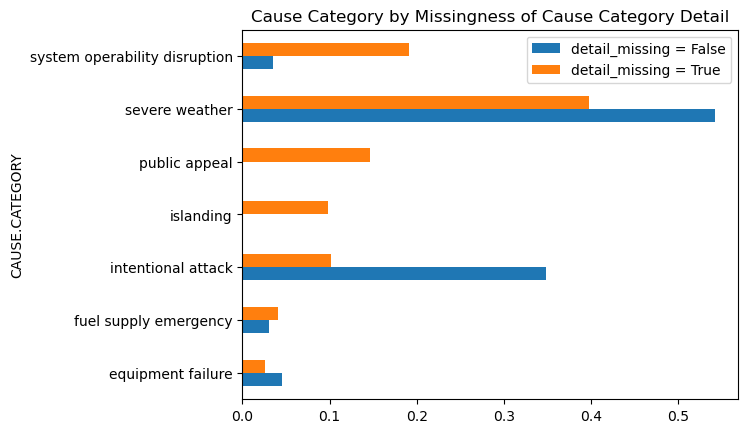

In [57]:
detail_dist = (missing_columns
               .pivot_table(index='CAUSE.CATEGORY', columns='detail_missing', aggfunc='size')
)
detail_dist.columns = ['detail_missing = False', 'detail_missing = True']
detail_dist = detail_dist.fillna(0)
detail_dist = detail_dist / detail_dist.sum()
detail_dist_plot = detail_dist.plot(kind='barh', title='Cause Category by Missingness of Cause Category Detail')

In [58]:
detail_dist

,detail_missing = False,detail_missing = True
CAUSE.CATEGORY,,
equipment failure,0.045155,0.025478
fuel supply emergency,0.030103,0.040340
intentional attack,0.348071,0.101911
islanding,0.000000,0.097665
public appeal,0.000000,0.146497
severe weather,0.541863,0.397028
system operability disruption,0.034807,0.191083


In [93]:
obs_detail = tvd(detail_dist['detail_missing = False'], detail_dist['detail_missing = True'])
obs_detail

np.float64(0.41067323382726845)

General permutation function

In [119]:
def permutation(df, col, bool_col, test_stat):
    test = df.copy()
    stats = []
    for _ in range(1000):
        test[bool_col] = np.random.permutation(df[bool_col])
        dist = (test
               .pivot_table(index=col, columns=bool_col, aggfunc='size')
        )
        dist.columns = [bool_col + ' = False', bool_col + ' = True']
        dist = dist.fillna(0)
        dist = dist / dist.sum()
        observed = test_stat(dist[bool_col + ' = False'], dist[bool_col + ' = True'])
        stats.append(observed)

    return np.array(stats)

In [125]:
stats_details = permutation(missing_columns, 'CAUSE.CATEGORY', 'detail_missing', tvd)
np.mean(stats_details >= obs_detail)

np.float64(0.0)

In [121]:
fig = px.histogram(stats_details, histnorm='probability', title='Empirical Distribution of the Permutation Tests TVD')
fig.add_vline(x=obs_detail, line_color='red', line_width=1, opacity=1)
fig.add_annotation(text=f'<span style="color:red">Observed TVD = {round(obs_detail, 2)}</span>', showarrow=False, y=0.045, x= 0.4)
fig.write_html('empirical_dist_cause_category_detail.html')

We have a p_val of 0, which means we can reject the null hypothesis of no dependence between the missingness of 'CAUSE.CATEGORY.DETAIL' and 'CAUSE.CATEGORY'. These two columns are highly likely to be dependent on one another.

Now, move on to test if the missingness of 'CUSTOMERS.AFFECTED' is dependent on 'CAUSE.CATEGORY.DETAIL'.

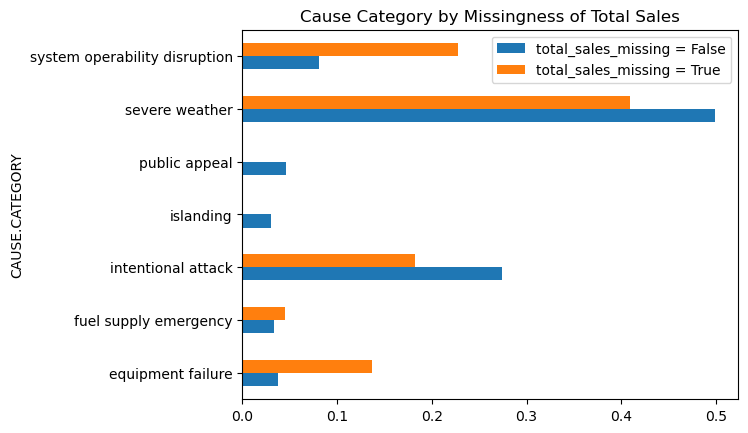

In [148]:
total_sales_dist = (missing_columns
               .pivot_table(index='CAUSE.CATEGORY', columns='total_sales_missing', aggfunc='size')
)
total_sales_dist.columns = ['total_sales_missing = False', 'total_sales_missing = True']
total_sales_dist = total_sales_dist.fillna(0)
total_sales_dist = total_sales_dist / total_sales_dist.sum()
customer_dist_plot = total_sales_dist.plot(kind='barh', title='Cause Category by Missingness of Total Sales')


In [149]:
obs_total_sales = tvd(total_sales_dist['total_sales_missing = False'], total_sales_dist['total_sales_missing = True'])
obs_total_sales

np.float64(0.25763588263588266)

In [151]:
total_sales_stats = permutation(missing_columns, 'CAUSE.CATEGORY', 'total_sales_missing', tvd)
p_val_total_sales = np.mean(total_sales_stats >= obs_total_sales)

In [152]:
p_val_total_sales

np.float64(0.087)

In [159]:
fig = px.histogram(total_sales_stats, histnorm='probability', title='Empirical Distribution of the Permutation Tests TVD')
fig.add_vline(x=obs_total_sales, line_color='red', line_width=1, opacity=1)
fig.add_annotation(text=f'<span style="color:red">Observed TVD = {round(obs_total_sales, 2)}</span>', showarrow=False, y=0.045, x= 0.3)

We have a p_val of ~0.017 which is greater than our significance level of 0.01. We cannot reject the null hypothesis (Month's missingness is not dependent on Cause.Category)

#### Now moving on to testing if the duration of California power outages are different from all other states' power outages

Null Hypothesis: On average, the durations of California power outages is the same as all other states' power outages.

Alternate Hypothesis: On average, the durations of California power outages is different than all other states' power outages.

For our test statistic, we will use a difference in means.

For our significance value, we will use a = 0.05 because this is a general exploratory analysis

In [161]:
state_duration = relevant.copy()[['U.S._STATE', 'OUTAGE.DURATION']]
state_duration

,U.S._STATE,OUTAGE.DURATION
OBS,,
1,Minnesota,3060.0
2,Minnesota,1.0
3,Minnesota,3000.0
4,Minnesota,2550.0
5,Minnesota,1740.0
...,...,...
1530,North Dakota,720.0
1531,North Dakota,NaN
1532,South Dakota,59.0


In [191]:
populated_duration_mean = state_duration[state_duration['U.S._STATE'].isin(['California', 'Texas', 'Florida'])]['OUTAGE.DURATION'].mean()
every_other_duration_mean = state_duration[state_duration['U.S._STATE'] != 'California']['OUTAGE.DURATION'].mean()

obs_duration = populated_duration_mean - every_other_duration_mean
obs_duration

np.float64(-461.1549960340426)

<Axes: xlabel='OBS'>

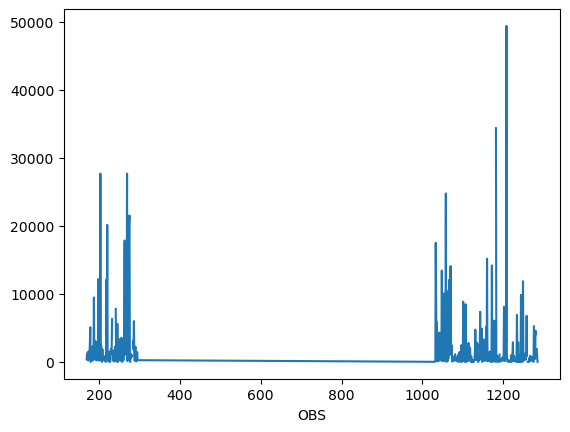

In [203]:
relevant['CAUSE.CATEGORY'].unique()

array(['severe weather', 'intentional attack',
       'system operability disruption', 'equipment failure',
       'public appeal', 'fuel supply emergency', 'islanding'],
      dtype=object)

In [176]:
test_stats = []
test_df = state_duration.copy()
for _ in range(10000):
    test_df['permutation'] = np.random.permutation(state_duration['OUTAGE.DURATION'])
    populated_mean = test_df[test_df['U.S._STATE'].isin(['California', 'Texas', 'Florida'])]['permutation'].mean()
    every_other_mean =  test_df[test_df['U.S._STATE'] != 'California']['permutation'].mean()
    test_obs = populated_mean - every_other_mean
    test_stats.append(test_obs)

p_val_duration = np.mean(test_stats >= obs_duration)
p_val_duration

np.float64(0.9389)

In [185]:
fig = px.histogram(test_stats, histnorm='probability', title='Empirical Distribution of the Difference of Means')
fig.add_vline(x=obs_duration, line_color='red', line_width=1, opacity=1)
fig.add_annotation(text=f'<span style="color:red">Observed TVD = {round(obs_duration, 2)}</span>', showarrow=False, y=0.04, x= -700)
fig.write_html('empirical_dist_diff_means.html')

### We will now build a model to predict the cause of a power outage.

Our baseline model will be a logistic regression model. It will estimate the probability of a binary outcome based on relevant variables.

For our features, we will use 'OUTAGE.DURATION' and 'CLIMATE.REGION'. 

I chose outage.duration because I noticed that a longer duration of the outage usually is caused by severe weather, while shorter durations are caused by vandalism and islanding.

I chose climate.region because usually some climates recieve more severe weather storms than others and may help predict our cause. 

In [204]:
relevant.isna().sum()

YEAR                       0
MONTH                      9
U.S._STATE                 0
POSTAL.CODE                0
NERC.REGION                0
CLIMATE.REGION             6
ANOMALY.LEVEL              9
CAUSE.CATEGORY             0
CAUSE.CATEGORY.DETAIL    471
RES.SALES                 22
OUTAGE.START               9
OUTAGE.RESTORATION        58
OUTAGE.DURATION           58
DEMAND.LOSS.MW           705
CUSTOMERS.AFFECTED       443
RES.SALES                 22
IND.SALES                 22
COM.SALES                 22
TOTAL.PRICE               22
TOTAL.SALES               22
TOTAL.CUSTOMERS            0
POPPCT_URBAN               0
POPDEN_URBAN               0
AREAPCT_URBAN              0
dtype: int64

To start, we must impute missing values in our features.

For the outage column, I will use the median. For the climate column, I will use the mode.

In [206]:
df = relevant.copy()[['CAUSE.CATEGORY', 'CLIMATE.REGION', 'MONTH']]
df['imputed_climate'] = df['CLIMATE.REGION'].fillna(df['CLIMATE.REGION'].value_counts().index[0])
df['imputed_months'] = df['MONTH'].fillna(df['MONTH'].value_counts().index[0])
df

,CAUSE.CATEGORY,CLIMATE.REGION,MONTH,imputed_climate,imputed_months
OBS,,,,,
1,severe weather,East North Central,Jul,East North Central,Jul
2,intentional attack,East North Central,May,East North Central,May
3,severe weather,East North Central,Oct,East North Central,Oct
4,severe weather,East North Central,Jun,East North Central,Jun
5,severe weather,East North Central,Jul,East North Central,Jul
...,...,...,...,...,...
1530,public appeal,West North Central,Dec,West North Central,Dec
1531,fuel supply emergency,West North Central,NaN,West North Central,Jun
1532,islanding,West North Central,Aug,West North Central,Aug


Since climate.region has categorical data, we will one hot encode the column.

In [208]:
features = pd.concat([df, pd.get_dummies(df[['imputed_climate', 'imputed_months']], dtype=int)], axis=1)
features = features.drop(columns=['CAUSE.CATEGORY', 'MONTH', 'CLIMATE.REGION', 'imputed_climate', 'imputed_months'])
features

,imputed_climate_Central,imputed_climate_East North Central,imputed_climate_Northeast,imputed_climate_Northwest,imputed_climate_South,imputed_climate_Southeast,imputed_climate_Southwest,imputed_climate_West,imputed_climate_West North Central,imputed_months_Apr,imputed_months_Aug,imputed_months_Dec,imputed_months_Feb,imputed_months_Jan,imputed_months_Jul,imputed_months_Jun,imputed_months_Mar,imputed_months_May,imputed_months_Nov,imputed_months_Oct,imputed_months_Sep
OBS,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1531,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1532,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0


In [255]:
X = features
y = df['CAUSE.CATEGORY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = DecisionTreeClassifier(max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [256]:
y_pred.shape[0]

307

In [257]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
weighted_f1

np.float64(0.5294782821871833)

In [258]:
precision = precision_score(y_test, y_pred, average='weighted')  # 'weighted' is used for multiclass
recall = recall_score(y_test, y_pred, average='weighted')
precision, recall

c:\Users\Stikes PC\.conda\envs\dsc80\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



(np.float64(0.5066421544434573), np.float64(0.5732899022801303))

In [263]:
np.unique(y)

array(['equipment failure', 'fuel supply emergency', 'intentional attack',
       'islanding', 'public appeal', 'severe weather',
       'system operability disruption'], dtype=object)

In [261]:
np.unique(y_test), np.unique(y_pred)

(array(['equipment failure', 'fuel supply emergency', 'intentional attack',
        'islanding', 'public appeal', 'severe weather',
        'system operability disruption'], dtype=object),
 array(['equipment failure', 'fuel supply emergency', 'intentional attack',
        'islanding', 'severe weather', 'system operability disruption'],
       dtype=object))

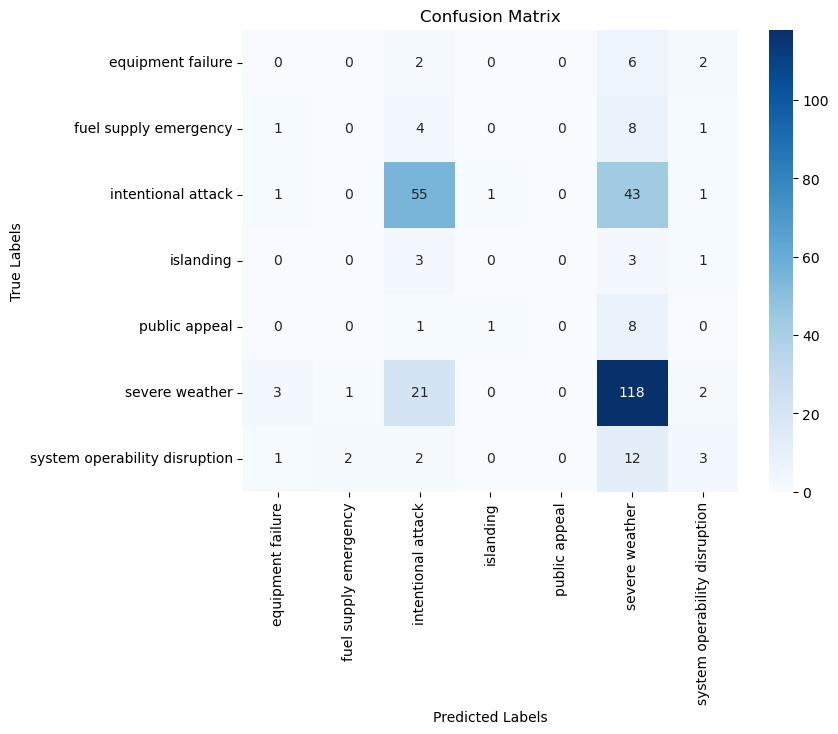

In [264]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [265]:
relevant

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,RES.SALES,OUTAGE.START,OUTAGE.RESTORATION,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,RES.SALES,IND.SALES,COM.SALES,TOTAL.PRICE,TOTAL.SALES,TOTAL.CUSTOMERS,POPPCT_URBAN,POPDEN_URBAN,AREAPCT_URBAN
OBS,,,,,,,,,,,,,,,,,,,,,,,,
1,2011,Jul,Minnesota,MN,MRO,East North Central,-0.3,severe weather,NaN,-0.594363,"Friday, July 01, 2011 17:00:00","Sunday, July 03, 2011 20:00:00",3060.0,NaN,70000.0,-0.594363,-0.308476,-0.660847,9.28,6562520.0,2595696,73.27,2279.0,2.14
2,2014,May,Minnesota,MN,MRO,East North Central,-0.1,intentional attack,vandalism,-0.815220,"Sunday, May 11, 2014 18:38:00","Sunday, May 11, 2014 18:39:00",1.0,NaN,NaN,-0.815220,-0.410267,-0.748638,9.28,5284231.0,2640737,73.27,2279.0,2.14
3,2010,Oct,Minnesota,MN,MRO,East North Central,-1.5,severe weather,heavy wind,-0.850659,"Tuesday, October 26, 2010 20:00:00","Thursday, October 28, 2010 22:00:00",3000.0,NaN,70000.0,-0.850659,-0.381646,-0.750375,8.15,5222116.0,2586905,73.27,2279.0,2.14
4,2012,Jun,Minnesota,MN,MRO,East North Central,-0.1,severe weather,thunderstorm,-0.736896,"Tuesday, June 19, 2012 04:30:00","Wednesday, June 20, 2012 23:00:00",2550.0,NaN,68200.0,-0.736896,-0.362797,-0.710488,9.19,5787064.0,2606813,73.27,2279.0,2.14
5,2015,Jul,Minnesota,MN,MRO,East North Central,1.2,severe weather,NaN,-0.684384,"Saturday, July 18, 2015 02:00:00","Sunday, July 19, 2015 07:00:00",1740.0,250.0,250000.0,-0.684384,-0.459947,-0.647453,10.43,5970339.0,2673531,73.27,2279.0,2.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,Dec,North Dakota,ND,MRO,West North Central,-0.9,public appeal,NaN,-1.140358,"Tuesday, December 06, 2011 08:00:00","Tuesday, December 06, 2011 20:00:00",720.0,155.0,34500.0,-1.140358,-1.088336,-1.140282,7.56,1313678.0,394394,59.90,2192.2,0.27
1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,fuel supply emergency,Coal,NaN,NaN,NaN,NaN,1650.0,NaN,NaN,NaN,NaN,NaN,NaN,366037,59.90,2192.2,0.27
1532,2009,Aug,South Dakota,SD,RFC,West North Central,0.5,islanding,NaN,-1.185060,"Saturday, August 29, 2009 22:54:00","Saturday, August 29, 2009 23:53:00",59.0,84.0,NaN,-1.185060,-1.165702,-1.159544,7.67,924051.0,436229,56.65,2038.3,0.30


In [277]:
reasoning_df = pd.DataFrame()
reasoning_df.index = ["YEAR", "U.S._STATE", "NERC.REGION", "ANOMALY.LEVEL", "RES.SALES", "IND.SALES", "COM.SALES"]
reasoning_df['Variable Type'] = ['qualitative ordinal', 'qualitative nominal', 'qualitative nominal', 'quantitative ordinal', 'quantiative nominal', 'quantitative nominal', 'quantitative nominal']
reasoning_df['Reasoning'] = ["Clear correlation between year and cause. We saw earlier that 2011 was more suspect to severe weather"
                             , "Some states are prone to more intentional attacks (e.g. New York)"
                             , "These regions reflect specific energy policies, compliance standards, and regional grid stress factors that may only apply to a respective region"
                             , "Has a direct relationship with climate and weather patterns that often lead to power disruptions"
                             , "Reflects demand patterns and grid stress."
                             , "Reflects demand patterns and grid stress."
                             ,"Reflects demand patterns and grid stress."]


In [280]:
print(reasoning_df.to_markdown())

|               | Variable Type        | Reasoning                                                                                                                                         |
|:--------------|:---------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------|
| YEAR          | qualitative ordinal  | Clear correlation between year and cause. We saw earlier that 2011 was more suspect to severe weather                                             |
| U.S._STATE    | qualitative nominal  | Some states are prone to more intentional attacks (e.g. New York)                                                                                 |
| NERC.REGION   | qualitative nominal  | These regions reflect specific energy policies, compliance standards, and regional grid stress factors that may only apply to a respective region |
| ANOMALY.LEVEL | quantitative ordinal | Has a direct r

In [307]:
final_features = relevant[reasoning_df.index].iloc[:, [0, 1, 2, 3, 5, 6, 7]]
final_features.isna().sum()

YEAR              0
U.S._STATE        0
NERC.REGION       0
ANOMALY.LEVEL     9
RES.SALES        22
IND.SALES        22
COM.SALES        22
dtype: int64

In [ ]:
numeric_features = ["YEAR", "ANOMALY.LEVEL", "RES.SALES", "IND.SALES"]
categorical_features = ["U.S._STATE", "NERC.REGION"]

X = final_features
y = relevant['CAUSE.CATEGORY']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical featuresa
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

DecisionTreeClassifier GridSearchCV

In [331]:
dt_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

# Define the parameter grid for max_depth
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, 15, 20, None]  # Trying different depths
}

# Use GridSearchCV to find the best max_depth
grid_search = GridSearchCV(dt_pipe, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
print("Best parameters:", grid_search.best_params_)

# Best cross-validation score
print("Best cross-validation score:", grid_search.best_score_)

# Optionally, test the model on the unseen test set
test_score = grid_search.score(X_test, y_test)
print("Test set score:", test_score)

Best parameters: {'classifier__max_depth': 5}
Best cross-validation score: 0.656084287373486
Test set score: 0.5960912052117264


RandomForestClassifier GridSearchCV

In [332]:
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

param_grid = {
    'classifier__n_estimators': [50, 100, 150],  # Number of trees in the forest
    'classifier__max_depth': [3, 5, 7, 10, None],  # Max depth of the trees
    'classifier__min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4],  # Minimum samples required to be at a leaf node
    'classifier__bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(rf_pipe, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Split the dataset into train and test sets (for example)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Output the best hyperparameters found by GridSearchCV
print("Best hyperparameters found by GridSearchCV:", grid_search.best_params_)

# Best model score from cross-validation
print("Best cross-validation score:", grid_search.best_score_)

# Test the best model on the test set
test_score = grid_search.score(X_test, y_test)
print("Test set accuracy:", test_score)

Best hyperparameters found by GridSearchCV: {'classifier__bootstrap': False, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Best cross-validation score: 0.6854521320723411
Test set accuracy: 0.6547231270358306


c:\Users\Stikes PC\.conda\envs\dsc80\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning:

invalid value encountered in cast



KNeighborsClassifier GridSearchCV

In [333]:
knn_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 10, 15],  # Number of neighbors to use
    'classifier__weights': ['uniform', 'distance'],  # Weight function used in prediction
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
    'classifier__leaf_size': [10, 20, 30, 40, 50],  # Leaf size passed to BallTree or KDTree
    'classifier__p': [1, 2]  # Power parameter for the Minkowski metric
}

grid_search = GridSearchCV(knn_pipe, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Split the dataset into train and test sets (for example)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Output the best hyperparameters found by GridSearchCV
print("Best hyperparameters found by GridSearchCV:", grid_search.best_params_)

# Best model score from cross-validation
print("Best cross-validation score:", grid_search.best_score_)

# Test the best model on the test set
test_score = grid_search.score(X_test, y_test)
print("Test set accuracy:", test_score)

Best hyperparameters found by GridSearchCV: {'classifier__leaf_size': 10, 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 15, 'classifier__p': 1, 'classifier__weights': 'distance'}
Best cross-validation score: 0.6699386095901776
Test set accuracy: 0.6254071661237784


c:\Users\Stikes PC\.conda\envs\dsc80\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning:

invalid value encountered in cast

c:\Users\Stikes PC\.conda\envs\dsc80\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning:

One or more of the test scores are non-finite: [0.627556   0.65525801 0.627556   0.65525801 0.63081135 0.66016592
 0.63081135 0.66016592 0.62186162 0.6642376  0.62186162 0.6642376
 0.63083126 0.66424755 0.63083126 0.66424755 0.64631492 0.66587357
 0.64631492 0.66587357        nan 0.65363199        nan 0.65363199
        nan 0.65772026        nan 0.65772026        nan 0.66179194
        nan 0.66179194        nan 0.66424755        nan 0.66424755
        nan 0.66993861        nan 0.66993861        nan 0.65363199
 0.627556   0.65525801        nan 0.65772026 0.63081135 0.66016592
        nan 0.66179194 0.62186162 0.6642376         nan 0.66424755
 0.63083126 0.66424755        nan 0.66993861 0.64631492 0.66587357
 0.627556   0.65525801 0.627556   0.65525801

We will go with RandomForestClassifier as our final algorithm

In [337]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit the model
rf_pipe.fit(X_train, y_train)

# Get predictions on the test set
y_pred = rf_pipe.predict(X_test)

# Compute the weighted F1 score
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print("Weighted F1 Score:", weighted_f1)

Weighted F1 Score: 0.6619489138848851


In [338]:
precision = precision_score(y_test, y_pred, average='weighted')  # 'weighted' is used for multiclass
recall = recall_score(y_test, y_pred, average='weighted')
precision, recall

(np.float64(0.6485693195249652), np.float64(0.6872964169381107))

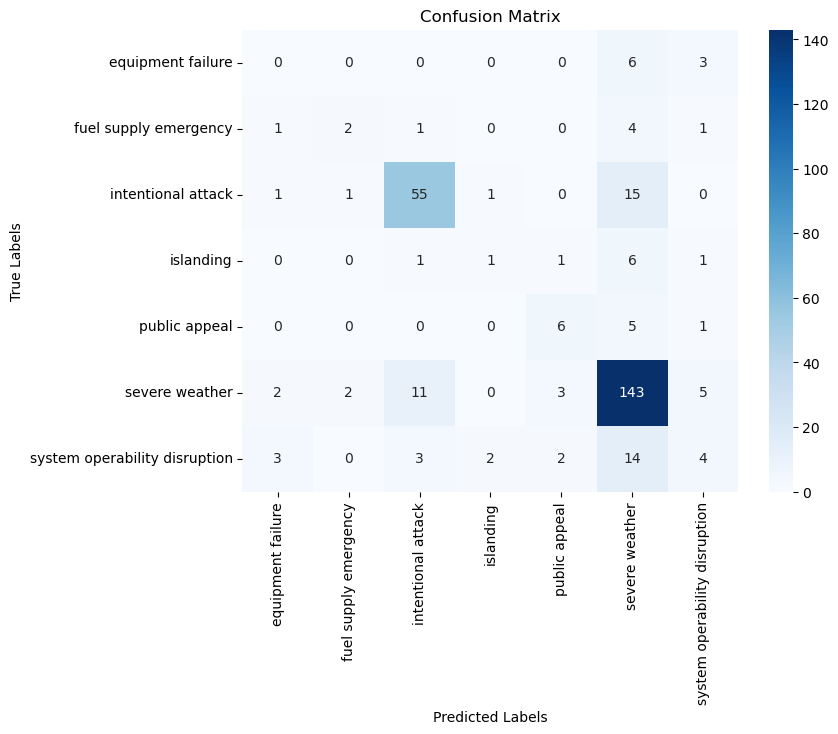

In [339]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [343]:
y_test

OBS
13                 intentional attack
186                     public appeal
304                    severe weather
21                     severe weather
1163                    public appeal
                    ...              
238     system operability disruption
549                    severe weather
107                    severe weather
359                 equipment failure
613                    severe weather
Name: CAUSE.CATEGORY, Length: 307, dtype: object

In [344]:
severe_weather_and_attack = ["severe weather", "intentional attack"]  # List your specific causes
group_mask_1 = np.isin(y_test, severe_weather_and_attack)  # Group 1
group_mask_2 = ~np.isin(y_test, severe_weather_and_attack)  # Group 2

# Calculate precision for both groups
precision_group_1 = precision_score(y_test[group_mask_1], y_pred[group_mask_1], average='weighted')
precision_group_2 = precision_score(y_test[group_mask_2], y_pred[group_mask_2], average='weighted')

# Observed difference in precision
observed_diff = precision_group_1 - precision_group_2
print(f"Observed precision for Group 1 (Severe Weather and Intentional Attack): {precision_group_1}")
print(f"Observed precision for Group 2 (Other causes): {precision_group_2}")
print(f"Observed difference in precision: {observed_diff}")

# Permutation test to assess the null hypothesis
num_permutations = 10000
perm_diffs = []

# Permutation test: shuffle the labels and calculate precision for each permutation
for _ in range(num_permutations):
    permuted_y = np.random.permutation(y_test)

    # Recalculate precision for the shuffled groups
    perm_precision_group_1 = precision_score(permuted_y[group_mask_1], y_pred[group_mask_1], average='weighted')
    perm_precision_group_2 = precision_score(permuted_y[group_mask_2], y_pred[group_mask_2], average='weighted')

    # Calculate the difference in precision for this permutation
    perm_diffs.append(perm_precision_group_1 - perm_precision_group_2)

# Calculate the p-value: proportion of permuted differences as extreme as or more extreme than the observed difference
p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
print(f"P-value: {p_value}")

Observed precision for Group 1 (Severe Weather and Intentional Attack): 0.8831541408470598
Observed precision for Group 2 (Other causes): 0.4637254901960784
Observed difference in precision: 0.4194286506509814
P-value: 0.0


In [350]:
fig = px.histogram(perm_diffs, histnorm='probability', title='Empirical Distribution of the Permutation Tests Precision Difference')
fig.add_vline(x=observed_diff, line_color='red', line_width=1, opacity=1)
fig.add_annotation(text=f'<span style="color:red">Observed TVD = {round(observed_diff, 2)}</span>', showarrow=False, y=0.03, x= 0.4)
fig